In [56]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [63]:
import numpy as np
import pandas as pd

In [64]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [65]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [66]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [67]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [68]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [69]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [70]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [29]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [30]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

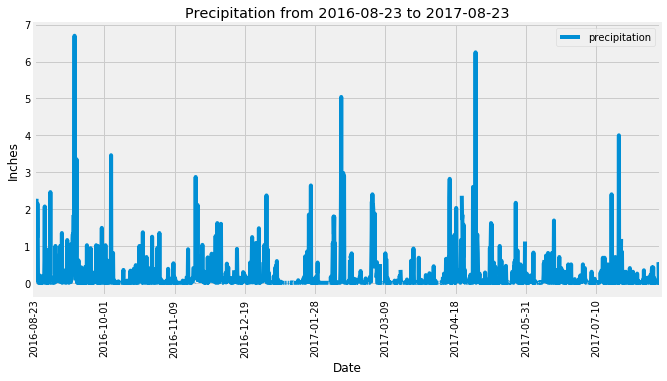

In [31]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
starting_date = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())
starting_date = list(np.ravel(starting_date))[0]
starting_date = dt.datetime.strptime(starting_date, '%Y-%m-%d')

s_year = int(dt.datetime.strftime(starting_date, '%Y'))
s_month = int(dt.datetime.strftime(starting_date, '%m'))
s_day = int(dt.datetime.strftime(starting_date, '%d'))

# Calculate the date 1 year ago fromthe last data point in the database
ending_date = dt.date(s_year, s_month, s_day) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_cal = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date >= ending_date)
                  .order_by(Measurement.date)
                  .all())
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(prcp_cal)
rain_df
rain_df_index = rain_df.set_index('date')
rain_df_index.head()
# Sort the dataframe by date
rain_df_index = rain_df_index.sort_index(ascending=True)
# Use Pandas Plotting with Matplotlib to plot the data
#plot data
fig, ax = plt.subplots(figsize = (10, 5))
rain_df_index.plot(ax = ax, rot=90)
ax.set_xlabel('Date')
ax.set_ylabel('Inches')
ax.legend(["precipitation"])
ax.set_title("Precipitation from 2016-08-23 to 2017-08-23")

plt.savefig("Images/precip.png")
plt.show()

In [32]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df_index.describe().round(2)

,prcp
count,2021.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [46]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Station).count()
stations_count

9

In [75]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [48]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = station_activity[0][0]
lowest_temp = session.query(func.min(Measurement.tobs)).\
                filter(Measurement.station == most_active_station).all()
highest_temp = session.query(func.max(Measurement.tobs)).\
                filter(Measurement.station == most_active_station).all() 
avg_temp = session.query(func.avg(Measurement.tobs)).\
                filter(Measurement.station == most_active_station).all() 

print(f"Most active station is: {most_active_station}")
print(f"Lowest Temp recorded is: {lowest_temp}")
print(f"Highest Temp recorded is: {highest_temp}")
print(f"The average temperture is: {avg_temp}")


Most active station is: USC00519281
Lowest Temp recorded is: [(54.0,)]
Highest Temp recorded is: [(85.0,)]
The average temperture is: [(71.66378066378067,)]


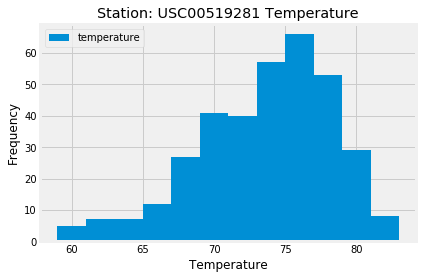

In [49]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= ending_date).all()
active_station_df = pd.DataFrame(active_station_temp, columns = ['date', 'temperature'])
active_station_df = active_station_df.set_index('date')
active_station_df.head()

fig, ax = plt.subplots()
active_station_df.plot.hist(bins = 12, ax = ax)

ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')
ax.set_title("Station: USC00519281 Temperature")

plt.savefig("Images/temphist.png")
plt.show()

## Bonus Challenge Assignment

In [37]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [38]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-03-1', '2017-03-15')

print(f"Trip day is from 2017-03-1 to 2017-03-15")
print(f"Lowest Temperature: {trip_temps[0][0]}")
print(f"Highest Temperature: {trip_temps[0][2]}")
print(f"Average Temperature: {round(trip_temps[0][1], 2)}")

Trip day is from 2017-03-1 to 2017-03-15
Lowest Temperature: 65.0
Highest Temperature: 82.0
Average Temperature: 71.89


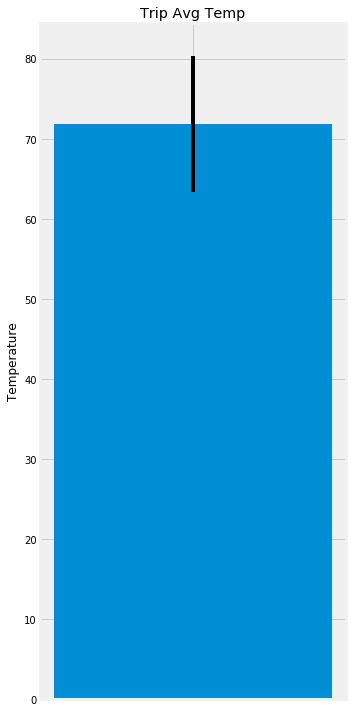

In [39]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak_to_peak = trip_temps[0][2] - trip_temps[0][0]
avg_temp = trip_temps[0][1]

fig, ax = plt.subplots(figsize = (5, 10))

ax.bar(1, avg_temp, yerr = peak_to_peak/2, width = 0.4)

ax.set_xticks([1])
ax.set_xticklabels([""])
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temperature')

#save fig
plt.savefig("Images/tempbar")

#show figure
plt.tight_layout()
plt.show()

In [45]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

total_rainfall = session.query(Station.station, station_table.name, Station.latitude, Station.longitude,
                               Station.elevation, func.avg(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= ending_date).group_by(Station.station).\
    order_by(func.avg(Measurement.prcp).desc()).all()
total_rainfall

total_rainfall_df = pd.DataFrame(total_rainfall, columns = ['Station', 'Name', 'Latitude', 'Longitude', 
                                                              'Elevation', 'Avg. Precipitation'])

total_rainfall_df

,Station,Name,Latitude,Longitude,Elevation,Avg. Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.450640
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.198949
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.141429
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.125434
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.121051
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.076500
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.044819


In [41]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [42]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = "2019-03-01"
end_date = "2019-03-15"
# Use the start and end date to create a range of dates
startNum = int(start_date[-2:])
endNum = int(end_date[-2:])
trip_len = endNum - startNum + 1

# Stip off the year and save a list of %m-%d strings
start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')

date_list = [dt.datetime.strftime(start_date + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, trip_len)]
date_list
# Loop through the list of %m-%d strings and calculate the normals for each date
trip_norms = [daily_normals(date) for date in date_list]
type(trip_norms)

list

In [43]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals = [np.array(normal[0]) for normal in trip_norms]

normals_df = pd.DataFrame(normals)

normals_df["Date"] = date_list

normals_df = normals_df.set_index("Date")
normals_df = normals_df.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})
normals_df

,Low Temp,Avg Temp,High Temp
Date,,,
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0
03-06,60.0,69.203390,76.0
03-07,60.0,69.172414,78.0
03-08,59.0,68.724138,78.0
03-09,57.0,68.561404,75.0


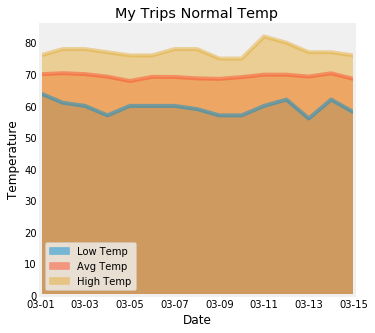

In [44]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(figsize = (5, 5))
normals_df.plot.area(ax = ax, stacked = False)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.set_title('My Trips Normal Temp')

plt.savefig('Images/dailynormarea.png')

plt.grid()
plt.show()